# Figure X. Trajectory table

Imports.

In [145]:
%load_ext autoreload
%autoreload 2
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

measure = 'sigma'
trial_indices = defaultdict(int)
records = []
path = '../../dgym-data/analysis/noise/selection_noise_2024-05-10_23-36-56_continued.zip'
with zipfile.ZipFile(path, 'r') as z:
    for filename in tqdm(z.namelist()):
        with z.open(filename) as file:
            with TextIOWrapper(file, encoding='utf-8') as text_file:
                result = json.load(text_file)
                
                # Get annotations
                record = pd.DataFrame(result['annotations']).reindex(
                    columns=[
                        'SMILES',
                        'Inspiration',
                        'Current Status',
                        'ABL1 pIC50',
                        'Log P',
                        'Log S',
                        'Noisy ABL1 pIC50',
                        'Noisy Log P',
                        'Noisy Log S',
                        'Step Tested',
                        'Step Scored',
                        'Synthetic Route',
                    ]
                )
                
                # Get trial number
                value = result[measure]
                trial_indices[value] += 1
                record[measure] = value
                record['trial'] = trial_indices[value]

                # Append
                records.append(record)
df = pd.concat(records)
records = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/500 [00:00<?, ?it/s]

Score utility.

In [146]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction(
    utility_functions = [docking_utility_function, log_P_utility_function, log_S_utility_function],
    weights = [0.8, 0.1, 0.1]
)

df['utility'] = composite_utility_function(
    df[['ABL1 pIC50', 'Log P', 'Log S']].values,
    precompute=True,
    method='average'
)

### Parse molecules

In [353]:
import ast
import dgym as dg
import numpy as np

subset = df.query('sigma == 2.0').query('trial == 2') # .query('sigma == 2.0').query('trial == 2')
current_row = subset.query('utility == 1.0').iloc[0]
lineage = []
while True:
    # Parse Molecule
    best = dict(current_row)
    route = best.pop('Synthetic Route')
    
    # Normalize inputs
    if isinstance(route, str):
        route = ast.literal_eval(route)
    if isinstance(best['Inspiration'], float):
        del best['Inspiration']
    route['annotations'] = best

    # Create Molecule
    mol = dg.molecule.Molecule.load(route)
    
    # Append Molecule
    lineage.append(mol)
    
    # Iterate to ancestor
    if not mol.inspiration:
        break

    inspiration_smiles = mol.inspiration.smiles
    current_row = subset.query(
        f'SMILES == "{inspiration_smiles}"').iloc[0]
    
lineage = dg.collection.MoleculeCollection(lineage)

### Fill out missing annotations

Load Oracles.

In [356]:
import os

def get_tcp_objectives():

    dockstring_dir = f'../../dgym-data/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'../../dgym-data//dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle

In [362]:
import dgym as dg
import io
from contextlib import redirect_stdout
f = io.StringIO()

untested = lineage[lineage.annotations.isna().any(axis=1)]

def complete_tests(molecules):
    """
    Perform all assays on molecules in batch.
    """
    oracles = get_tcp_objectives()
    with redirect_stdout(f):
        results = [oracle(molecules, batch_size=40) for oracle in oracles]
        for idx, result in enumerate(results):
            for jdx, r in enumerate(result):
                molecules[jdx][oracles[idx].name] = r
    return molecules

untested = complete_tests(untested)

In [358]:
from rdkit.Chem import Draw

def plot_aligned_molecules(
    molecules,
    mols_per_row=3,
    use_svg=True
):
    """
    Plots a list of RDKit molecules.

    Parameters
    ----------
    molecules : list
        A list of RDKit molecule objects.
    """
    mols = [m.mol for m in molecules]
    img = Draw.MolsToGridImage(
        mols,
        subImgSize=(325, 325), # 250
        molsPerRow=mols_per_row,
        useSVG=use_svg,
    )
    return img

In [371]:
for idx, _ in enumerate(lineage):
    if idx < len(lineage) - 1:
        lineage[idx].inspiration = lineage[idx+1]

aligned_molecules = dg.utils.align_lineage(lineage[0])

In [373]:
# plot_aligned_molecules(aligned_molecules, mols_per_row=1, use_svg=True)

## Representative early-optimization molecules

In [230]:
# Convert step made to Progress of Series as in Novartis paper.
df['Progress'] = (
    df
    .groupby(['sigma', 'trial'])['Step Scored']
    .transform(lambda x: x / x.max() * 100)
)

In [12]:
progresses = [0, 1, 2, 5, 10, 20, 40, 80, 99]
mol_progress = []
for progress in progresses:
    if progress == 0:
        subset = df[df['Inspiration'].isna()]
    else:
        subset = (
            df
            .query(f'Progress > {progress}')
            .query(f'Progress < {progress} + 1')
        )
    representative_molecules = [dg.molecule.Molecule(
        subset
        .sample()['SMILES']
        .item()
    ) for _ in range(4)]
    mol_progress.append(representative_molecules)
mols = np.array(mol_progress).T.ravel()

In [13]:
from rdkit.Chem import AllChem
import rdkit.Chem.Draw
from rdkit.Chem.Draw import rdMolDraw2D
try:
    import Image
except ImportError:
    from PIL import Image
from io import BytesIO

def DrawMolsZoomed(mols, molsPerRow=3, subImgSize=(500, 500)):
    """
    From https://sourceforge.net/p/rdkit/mailman/message/36477772/
    """
    nRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow: nRows += 1
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
    full_image = Image.new('RGBA', fullSize )
    for ii, mol in enumerate(mols):
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
        column = ii % molsPerRow
        row = ii // molsPerRow
        offset = ( column * subImgSize[0], row * subImgSize[1] )
        d2d = rdMolDraw2D.MolDraw2DCairo(int(subImgSize[0] * 0.75), subImgSize[1])
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()
        sub = Image.open(BytesIO(d2d.GetDrawingText()))
        full_image.paste(sub,box=offset)
    return full_image

In [269]:
# plot_aligned_molecules(aligned_molecules, mols_per_row=3)

In [268]:
# DrawMolsZoomed([m.mol for m in mols], molsPerRow=9)

## Best molecules across round

In [348]:
great_example = (
    df
    .query('sigma == 1.0')
    .query('Progress == 100')
    .sort_values('ABL1 pIC50', na_position='last', ascending=False)
    .iloc[3]
)

great_example

SMILES              O=C1CNCCN1C(=O)c1ccc2c(c1)NC(=O)N(C(=O)C1CCN(C...
Inspiration         CCOC(=O)N1CCC(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O)c5...
Current Status                                                 Tested
ABL1 pIC50                                                   9.461346
Log P                                                          0.7064
Log S                                                       -3.693619
Noisy ABL1 pIC50                                              9.23914
Noisy Log P                                                  0.808047
Noisy Log S                                                 -2.272971
Step Tested                                                      17.0
Step Scored                                                      16.0
Synthetic Route     {'product': 'O=C1CNCCN1C(=O)c1ccc2c(c1)NC(=O)N...
sigma                                                             1.0
trial                                                              95
utility             

Find best molecules across round `sigma == 1.0`, `trial == 95` (`.iloc[3]` above).

In [345]:
import pandas as pd

# Subset to a certain trial
subset = df.query('sigma == 1.0').query('trial == 95')

# Find maximum value for each step
max_per_step = subset.groupby('Step Tested')['utility'].max().reset_index()

# Calculate global cumulative maximum of the max values per step
global_cum_max = max_per_step['utility'].cummax()

# Filter steps where the maximum is also a new global maximum
new_global_max_steps = max_per_step[max_per_step['utility'] == global_cum_max]

# Find the indices in the original DataFrame
# Use 'index' from reset_index() to get original indices
indices = subset.reset_index().merge(
    new_global_max_steps[['Step Tested', 'utility']],
    on=['Step Tested', 'utility'],
    how='inner'
)['index'].astype(int).tolist()

Compute utility for hits.

In [263]:
hits = subset.iloc[:5]
hits = dg.collection.MoleculeCollection([
    dg.molecule.Molecule(h) for h in hits['SMILES']
])
hits = complete_tests(hits)

with redirect_stdout(f):
    hit_utility = composite_utility_function(
        hits.annotations[['ABL1 pIC50', 'Log P', 'Log S']].values,
        method='average'
    )
    
best_hit = np.argmax(hit_utility)

In [264]:
best_across_rounds = [best_hit, *indices]
hits.annotations.iloc[best_hit]

SMILES                            Cc1ccc(C)c(OC(=O)c2ccncc2)c1
Design Cycle                                                 0
Reactants                                                   []
Synthetic Route    {'product': 'Cc1ccc(C)c(OC(=O)c2ccncc2)c1'}
Current Status                                            None
ABL1 pIC50                                            7.055282
Log P                                                  2.91764
Log S                                                -3.627151
Name: 3, dtype: object

In [265]:
subset.iloc[best_across_rounds]

,SMILES,Inspiration,Current Status,ABL1 pIC50,Log P,Log S,Noisy ABL1 pIC50,Noisy Log P,Noisy Log S,Step Tested,Step Scored,Synthetic Route,sigma,trial,utility,Progress
3,Cc1ccc(C)c(OC(=O)c2ccncc2)c1,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'product': 'Cc1ccc(C)c(OC(=O)c2ccncc2)c1', 'r...",1.0,95,-1000.000000,NaN
40,CC1CNc2c(C(=O)N3CCN(C(=O)c4cc(Cl)c[nH]4)CC3=O)...,CC1CNc2c(C(=O)N3CCNCC3=O)cnn2C1,Tested,7.777940,1.0510,-3.203693,8.201096,1.010342,-4.388655,1.0,0.0,{'product': 'CC1CNc2c(C(=O)N3CCN(C(=O)c4cc(Cl)...,1.0,95,-0.194745,0.00
160,CC1CNc2c(C(=O)N3CCN(C(=O)C4(c5cccc(C(=O)NCC6CC...,CC1CNc2c(C(=O)N3CCN(C(=O)c4ccccc4OCC(=O)NCC4CC...,Tested,8.512790,1.3963,-3.792963,10.960604,0.679194,-3.808785,3.0,2.0,{'product': 'CC1CNc2c(C(=O)N3CCN(C(=O)C4(c5ccc...,1.0,95,0.610232,12.50
297,CC1CNc2c(C(=O)N3CCN(C(=O)C4(c5cccc(C(=O)N[C@@H...,CC1CNc2c(C(=O)N3CCN(C(=O)C4(c5cccc(C(=O)NCC6CC...,Tested,8.648735,0.9542,-3.642773,8.437725,1.655361,-4.144227,10.0,4.0,{'product': 'CC1CNc2c(C(=O)N3CCN(C(=O)C4(c5ccc...,1.0,95,0.718988,25.00
476,CCOC(=O)N1CCC(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O)c5...,CCOC(=O)N1CCC(C(=O)N2CCN(C(=O)c3cnn4c3N(C(=O)c...,Tested,8.850764,1.4162,-4.150869,8.275719,1.392053,-3.536795,11.0,6.0,{'product': 'CCOC(=O)N1CCC(C(=O)N2Cc3ccc(C(=O)...,1.0,95,0.748161,37.50
883,Cn1c(C(=O)N2CCN(C(=O)C3(c4cccc(C(=O)N[C@@H]5CO...,CC1CNc2c(C(=O)N3CCN(C(=O)C4(c5cccc(C(=O)N[C@@H...,Tested,9.103744,2.1878,-4.434922,10.558196,1.219837,-4.552882,12.0,11.0,{'product': 'Cn1c(C(=O)N2CCN(C(=O)C3(c4cccc(C(...,1.0,95,0.794100,68.75
1016,O=C(c1cc(F)n[nH]1)N1CCN(C(=O)c2ccc3c(c2)NC(=O)...,CCOC(=O)N1CCC(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O)c5...,Tested,9.258308,1.0573,-4.081173,8.948356,0.945814,-2.860145,14.0,13.0,{'product': 'O=C(c1cc(F)n[nH]1)N1CCN(C(=O)c2cc...,1.0,95,0.883107,81.25
1186,O=C1CNCCN1C(=O)c1ccc2c(c1)NC(=O)N(C(=O)C1CCN(C...,CCOC(=O)N1CCC(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O)c5...,Tested,9.461346,0.7064,-3.693619,9.239140,0.808047,-2.272971,17.0,16.0,{'product': 'O=C1CNCCN1C(=O)c1ccc2c(c1)NC(=O)N...,1.0,95,1.000000,100.00


In [267]:
# best_molecules = []
# for smiles in subset.iloc[best_across_rounds]['SMILES']:
#     best_molecules.append(dg.molecule.Molecule(smiles))

# plot_aligned_molecules(best_molecules, mols_per_row=1)

## Plot synthetic route

In [287]:
route = ast.literal_eval(great_example['Synthetic Route'])

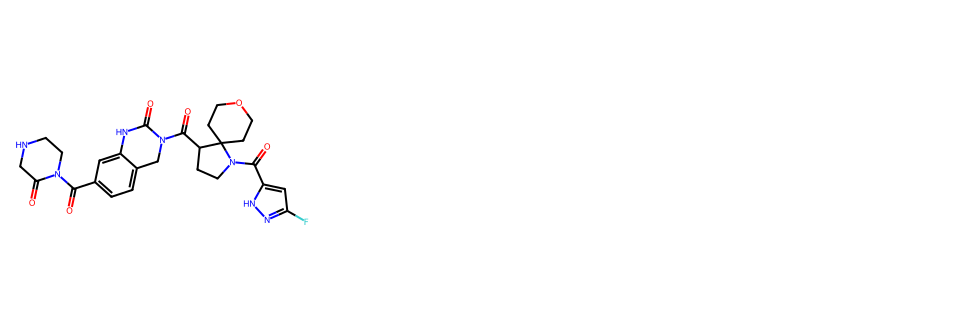

In [352]:
plot_aligned_molecules([
    dg.molecule.Molecule(route['product'])
])

Assign Enamine ID

In [343]:
import chemfp

# Grab reactant
mols = [dg.molecule.Molecule(
    route['reactants'][0]['reactants'][1]['product']
)]

# Compute fingerprint
fingerprints = dg.datasets.fingerprints(f'../../dgym-data/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')
fingerprint_type = fingerprints.get_fingerprint_type()
query_fingerprints = [
    (m.name, fingerprint_type.from_smi(m.smiles))
    for m in mols
]

queries = chemfp.load_fingerprints(
    query_fingerprints,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

results = chemfp.simsearch(
    queries = queries,
    targets = fingerprints,
    progress = False,
    threshold = 0.0,
)

(
    results
    .to_pandas()
    .sort_values('score', ascending=False)
).head(1)

,query_id,target_id,score
237890,Cl.O=C(O)C1CCNC12CCOCC2,EN300-6760175 14,1.0
